[https://qiita.com/tanaka_soichiro/items/56c02ad53bc0babe62ab](https://qiita.com/tanaka_soichiro/items/56c02ad53bc0babe62ab)

In [224]:
import numpy as np
from numpy import pi, exp, log
from numpy import dot, multiply, diag, power
from numpy.linalg import inv, eig, pinv
import matplotlib.pyplot as plt

In [225]:
output_dir = "analysis/"
N = 200
OBSERVASION_TIME = 1
t_raw = np.linspace(0, OBSERVASION_TIME, N)

dt = t_raw[2] - t_raw[1]
trend = 10 * (t_raw - OBSERVASION_TIME) ** 2
periodic1 = np.sin(10 * 2 * pi * t_raw) / exp(-2 * t_raw)
periodic2 = np.sin(20 * 2 * pi * t_raw)
np.random.seed(123)
noise = 1.5 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

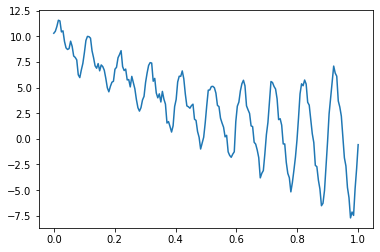

In [226]:
plt.plot(t_raw, F)

In [227]:
# 前処理(Hanakel行列化)
# N: 時系列の長さ, L: 任意のwinidowの大きさ, Nの半分以下にしないといけない
L = 70
K = N - L + 1
D = np.column_stack([F[i : i + L] for i in range(0, K)])
D.shape # (1windowに格納されている状態ベクトルの数, スナップショットの数)

(70, 131)

In [228]:
X = D[:, :-1]  # スナップショット群1
Y = D[:, 1:]  # スナップショット群2
t = np.arange(0, K - 1)  # スナップショット群に対するtime

In [229]:
# Y = AXとなるAを求める
# ここでsvdを施し、次元削減
U2, Sig2, Vh2 = np.linalg.svd(X)
print(U2.shape, Sig2.shape, Vh2.shape)

(70, 70) (70,) (130, 130)


In [230]:
# 寄与率を見ておく
sigma_sumsq = (Sig2 ** 2).sum()
cumlative_contrib = (Sig2 ** 2).cumsum() / sigma_sumsq * 100

$$
A^{tilde} = U_r^* A U_r = U_r^* Y V_r \Sigma_r^{-1}
$$
ただし$U^*$は$U$の随伴行列（転置の複素共役とったやつ）

In [231]:

r = 5
U = U2[:,:r]
Sig = diag(Sig2)[:r,:r]  # 対角行列を作って、それのrランク
V = Vh2.conj().T[:,:r]  # conjは共役複素数

Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig))

In [232]:
mu, W = eig(Atil)  # 固有値と固有ベクトルを作成

In [233]:
freqs = np.angle(mu) / (2 * pi * dt)
for idx, freq in enumerate(freqs):
    print("mode" + str(idx) + " freq=" + str(freq))

mode0 freq=0.0
mode1 freq=9.989363517060186
mode2 freq=-9.989363517060186
mode3 freq=19.957930838631473
mode4 freq=-19.957930838631473


# 時間発展を考える

固有値$w_i$,固有ベクトル$\phi_i$ $(i=0, 1, r)$

$$
x(t) = \Sigma \phi_j \exp (w_j t) b_j = \Phi \exp(\Omega t) \bm{b}
$$

$$
\Omega = diag(w_j), w_j = \frac{\log(\lambda_)}{\Delta t}
$$

$$
\Phi = Y V_r \Sigma_r^{-1} W
$$

$$
b = \Phi^{\dagger} X
$$

In [234]:
Phi = dot(dot(dot(Y, V), inv(Sig)), W)
b = dot(pinv(Phi), X[:, 0])
Psi = np.zeros([r, len(t)], dtype="complex")
for idx, mu_elem in enumerate(mu):
    for _k in t:
        Psi[idx, _k] = exp(log(mu_elem) / dt * _k * dt) * b[idx]

In [235]:
# Compute DMD reconstruction for each mode
x_t_list = []
for idx, mu_elem in enumerate(mu):
    x_t = []
    for t_ in t:
        x_t.append(Phi[:, idx] * exp(log(mu_elem) / dt * t_ * dt) * b[idx])
    x_t = np.array(x_t).T
    x_t_list.append(x_t)
    # x_t_listには各モードの時間発展がかくのうされている

def X_to_TS(x_t):
    x0 = x_t[:, 0]
    x1 = x_t[-1, 1:]
    ts = np.concatenate([x0, x1], 0)
    print(ts.shape)
    return ts



# Convert Hankel matrix to time-series
x_t_recon = []
for x_t in x_t_list:
    x_t_recon.append(X_to_TS(x_t))
x_t_recon = np.array(x_t_recon)
F_recon = x_t_recon.sum(axis=0)

(199,)
(199,)
(199,)
(199,)
(199,)


/home/ayumu/Documents/MAZIN/DynamicModeDecomposition/myvenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


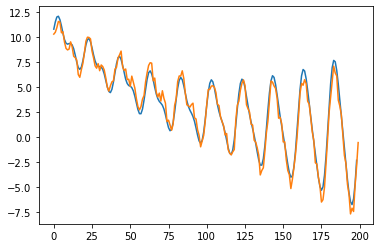

In [236]:
plt.plot(range(len(F_recon)), F_recon)
plt.plot(range(len(F)), F)

# 微分方程式を定義して時間発展させる
$$
\frac{dx}{dt} = \Sigma \phi_j w_j \exp(w_j t)b_j
$$

In [237]:
dF = F_recon[1:] - F_recon[:-1]
F_recon = np.zeros_like(F_recon)
F_recon[0] = F[0]

print(F_recon.shape, dF.shape)
for t in range(1, len(F_recon)):
	F_recon[t] = F_recon[t-1] + dF[t-1]
	

(199,) (198,)


/home/ayumu/Documents/MAZIN/DynamicModeDecomposition/myvenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


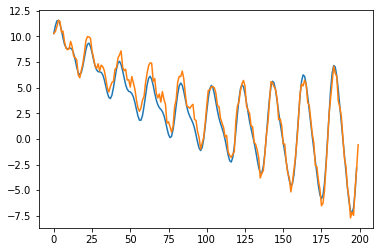

In [238]:
plt.plot(range(len(F_recon)), F_recon)
plt.plot(range(len(F)), F)